In [13]:
import numpy as np
import pandas as pd
import spacy
from bidi.algorithm import get_display

from googletrans import Translator
translator = Translator()

# Test word vectors

In [4]:
vec_path = '/Users/pabloherrero/Documents/ManHatTan/notebooks/he_vectors'
nlp = spacy.load(vec_path)

In [5]:
doc = nlp("זהו טקסט בעברית.")
for token in doc:
    print(token.text, token.has_vector, token.vector_norm)

זהו True 1.0681664
טקסט True 0.8047567
בעברית True 0.40524793
. True 1.5317025


In [20]:
doc = nlp("חברה שלי פיפו לא אדום.")
for token in doc:
    print(token.text, token.has_vector, token.vector_norm)

חברה True 0.77420473
שלי True 1.0418928
פיפו True 0.0
לא True 1.9327171
אדום True 0.83313257
. True 1.5317025


# Search for similar words

## Arbitrary word

In [22]:
adom_id = nlp.vocab.strings['אדום']
adom_vec = nlp.vocab.vectors[adom_id]
most_similar_words = nlp.vocab.vectors.most_similar(np.asarray([adom_vec]), n=5)
words = [nlp.vocab.strings[w] for w in most_similar_words[0][0]]
words


['אדום', 'כחול', 'צהוב', 'ירוק', 'שחור']

In [ ]:
adom_id = nlp.vocab.strings['אמרתי']
adom_vec = nlp.vocab.vectors[adom_id]
most_similar_words = nlp.vocab.vectors.most_similar(np.asarray([adom_vec]), n=8)
words = [nlp.vocab.strings[w] for w in most_similar_words[0][0]]
words

['אמרתי', 'ואמרתי', 'אגיד', 'חשבתי', 'ידעתי', 'שאמרתי', 'אומר', 'אמר']

## Test on LIP

In [15]:
lippath = '/Users/pabloherrero/Documents/ManHatTan/data/processed/LIPSTICK/hebrew_db.lip'
lip = pd.read_csv(lippath)
lip.set_index('word_ll', inplace=True, drop=False)

In [157]:

# Load your spaCy model that contains the Hebrew vectors
nlp = spacy.load("he_vectors")

# Define the target word and process it to get its token (make sure it has a vector)
target_word = "עכביש"
target_token = nlp(target_word)[0]

other_words = lip.word_ll.values.tolist()  # List of words to compare with the target word
# Compute similarity for each word in the list
similarities = []
for word in other_words:
    token = nlp(word)[0]
    # Check if both tokens have vectors
    if target_token.has_vector and token.has_vector:
        sim = target_token.similarity(token)
        similarities.append((word, sim))
    else:
        similarities.append((word, 0.0))

# Sort words by similarity in descending order
similarities.sort(key=lambda x: x[1], reverse=True)

# Print the top 10 most similar words
for word, score in similarities[:10]:
    print(f"{word}: {score:.3f}, {lip.loc[word, 'word_ul']}")


עכביש: 1.000, spider
קוף: 0.344, monkey
מפלצת: 0.316, monster
נחש: 0.286, snake
יצור: 0.260, creature
מכשפה: 0.259, witch
קוסם: 0.257, magician
מיקרופון: 0.254, microphone
טיפש: 0.251, Stupid
שריון: 0.251, armor


## Write word vectors

In [167]:
all_entries = lip.word_ll.values.tolist()
vect_word = []
vectors = []
for word in all_entries:
    token = nlp(word)[0]
    # Check if both tokens have vectors
    if target_token.has_vector and token.has_vector:
        vect_word.append(word)
        vectors.append(token.vector)

In [ ]:
pathout = '/Users/pabloherrero/Documents/ManHatTan/data/processed/vectors_lip/vectors_heb_lip.npz'

np.savez(pathout, tokens=vect_word, vectors=vectors)

# Load word vectors from npz file

In [178]:
data = np.load(pathout)
tokens = data['tokens']
vectors = data['vectors']
token_to_vector = {token: vector for token, vector in zip(vect_word, vectors)}


In [190]:
specific_word = 'עכביש'
specific_vector = token_to_vector[specific_word]
similarities = []
norm = np.dot(specific_vector, specific_vector)
for word in tokens:
    token = token_to_vector[word]
    sim = np.dot(specific_vector, token) / norm
    similarities.append((word, sim))
similarities.sort(key=lambda x: x[1], reverse=True)
# Print the top 10 most similar words
for word, score in similarities[1:4]:
    print(f"{word}: {score:.3f}, {lip.loc[word, 'word_ul']}")

קוף: 0.659, monkey
חץ: 0.574, arrow
נחש: 0.503, snake


# EGGS: Functions to sample similar words

In [200]:
from random import sample

def load_similar_words(pathout, target_word):
    word_vectors = np.load(pathout)
    tokens = word_vectors['tokens']
    vectors = word_vectors['vectors']
    token_to_vector = {token: vector for token, vector in zip(tokens, vectors)}
    try:
        target_vector = token_to_vector[target_word]
    except IndexError as e:
        print(e, f' with {target_word}')
        return
    similarities = []

    norm = np.dot(target_vector, target_vector)
    for word in tokens:
        token = token_to_vector[word]
        sim = np.dot(target_vector, token) / norm
        similarities.append((word, sim))
    similarities.sort(key=lambda x: x[1], reverse=True)
    # return the top 3 most similar words
    return [word for word, _ in similarities[1:10]]

def sample_similar_options(lipstick_path : str, iquest : int, modality : str, n_options : int = 3):

    if modality == 'dt': word_lang = 'word_ul'
    elif modality == 'rt': word_lang = 'word_ll'
    else: print('Incorrect modality in rnd_options function')
    lip = pd.read_csv(lipstick_path)
    target_word = lip.iloc[iquest]['word_ll']
    lip = lip.set_index('word_ll', drop=False)
    options = {}
    #### Change this: to be extracted from lipstick_path:
    vector_path = '/Users/pabloherrero/Documents/ManHatTan/data/processed/vectors_lip/vectors_heb_lip.npz'
    similar_words = load_similar_words(vector_path, target_word=target_word)
    
    rnd_similar_words = sample(similar_words, n_options)
    print(rnd_similar_words)
    for i in range(n_options):
        rndOp = lip.loc[rnd_similar_words][word_lang]
        print(rndOp)
        # options[rndOp] = False
    return options


In [199]:
vector_path = '/Users/pabloherrero/Documents/ManHatTan/data/processed/vectors_lip/vectors_heb_lip.npz'
load_similar_words(pathout=vector_path, target_word='עכביש')

['קוף', 'חץ', 'נחש', 'חכם', 'פשע', 'פחד', 'תת קרקעי', 'קוסם', 'מה אתה מסתכל']

In [201]:
iquest = 4
sample_similar_options(lipstick_path=lippath, iquest=iquest, modality='dt', n_options=4)

['נקי', 'מה נראה לך', 'רחב', 'יבש']
word_ll
נקי                         net
מה נראה לך    What do you think
רחב                        wide
יבש                         dry
Name: word_ul, dtype: object
word_ll
נקי                         net
מה נראה לך    What do you think
רחב                        wide
יבש                         dry
Name: word_ul, dtype: object
word_ll
נקי                         net
מה נראה לך    What do you think
רחב                        wide
יבש                         dry
Name: word_ul, dtype: object
word_ll
נקי                         net
מה נראה לך    What do you think
רחב                        wide
יבש                         dry
Name: word_ul, dtype: object


{}

# EGGS: Simple filtering out-of-bags words

## Drop words contained in original (simple prefixes and suffixes)

In [ ]:
selected_word = 'להגיע'
# selected_word = get_display(selected_word)
selected_word_id = nlp.vocab.strings['להגיע']
sel_word_vec = nlp.vocab.vectors[selected_word_id]
most_similar_words = nlp.vocab.vectors.most_similar(np.asarray([sel_word_vec]), n=5)
words = [nlp.vocab.strings[w] for w in most_similar_words[0][0]]

filtered_words = []
for w in words:
    if selected_word in w:
        print('Contained in original: ', w)
        continue
    filtered_words.append(w)
filtered_words

Contained in original:  להגיע
Contained in original:  ולהגיע


['להיכנס', 'לגשת', 'להתקרב']

## Account for different sofit letters (map to non-sofit)

In [8]:
def filter_sofits(word):
    from hebrew import FINAL_MINOR_LETTER_MAPPINGS as sofit_dict
    final_letter = word[-1]
    if final_letter in sofit_dict.keys():
        filtered_word = word[:-1] + sofit_dict[final_letter]
        return filtered_word
    else:
        return word

In [191]:
selected_word = 'כונה'
# selected_word = get_display(selected_word)
selected_word_id = nlp.vocab.strings[selected_word]
sel_word_vec = nlp.vocab.vectors[selected_word_id]
most_similar_words = nlp.vocab.vectors.most_similar(np.asarray([sel_word_vec]), n=30)
words = [nlp.vocab.strings[w] for w in most_similar_words[0][0]]
selected_filtered = filter_sofits(selected_word)
filtered_words = []
for w in words:
    wf = filter_sofits(w)
    if selected_filtered in wf:
        print('Contained in original: ', w)
        continue
    filtered_words.append(w)
filtered_words

Contained in original:  כונה
Contained in original:  מכונה
Contained in original:  ומכונה
Contained in original:  שכונה
Contained in original:  המכונה
Contained in original:  שמכונה


['נקרא',
 'כונתה',
 'קרוי',
 'לכינוי',
 'כונו',
 'ונקרא',
 'כינו',
 'כינויו',
 'בכינוי',
 'כינה',
 'שנקרא',
 'שימש',
 'הקרוי',
 'הוחלף',
 'שנודע',
 'נקראה',
 'הידוע',
 'הוגדר',
 'בכינויו',
 'התפרסם',
 'הוכר',
 'הפך',
 'נקראו',
 'נודעה']

#### Reverse order: the most similar words are typically the ones with the same root, so not so interesting

In [193]:
filtered_words[::-1]

['נודעה',
 'נקראו',
 'הפך',
 'הוכר',
 'התפרסם',
 'בכינויו',
 'הוגדר',
 'הידוע',
 'נקראה',
 'שנודע',
 'הוחלף',
 'הקרוי',
 'שימש',
 'שנקרא',
 'כינה',
 'בכינוי',
 'כינויו',
 'כינו',
 'ונקרא',
 'כונו',
 'לכינוי',
 'קרוי',
 'כונתה',
 'נקרא']

#### Sampling randomly

In [196]:
from random import sample
sample(filtered_words, 5)

['ונקרא', 'נודעה', 'נקראו', 'כונתה', 'בכינוי']

# Advanced filtering OOB words

OOB: Out-of-bag

## With Google Translator API

In [7]:
from googletrans import LANGUAGES

In [ ]:
from googletrans import Translator
translator = Translator()

In [60]:
import asyncio
from googletrans import Translator


In [158]:
len(filtered_words)

15

In [203]:
translator = Translator()

possible_words = sample(filtered_words, 5)
translations = await translator.translate(possible_words, dest='en')
translated_words = [t.text for t in translations]
lang_detection = await translator.detect(translated_words)
detected_lang = [lang.lang for lang in lang_detection]

gota = pd.DataFrame(columns=['word_ll', 'word_ul', 'ui_language', 'learning_language'])
filtered_translations = []

for i, (word_ll, word_ul, detected_lang) in enumerate(zip(filtered_words[:10], translated_words, detected_lang)):
    if detected_lang == translations[0].src:
        print(f"Failed to translate: {word_ll} -> {word_ul}")
        possible_words.remove(word_ll)
    else:
        print(f"Translation: {word_ll} -> {word_ul}")
        filtered_translations.append(word_ul)
gota['word_ll'] = possible_words
gota['word_ul'] = filtered_translations
gota['ui_language'] = 'en'
gota['learning_language'] = 'iw'
gota

Translation: נקרא -> named
Failed to translate: כונתה -> כונתה
Translation: קרוי -> His nickname
Translation: לכינוי -> To
Translation: כונו -> Were called


,word_ll,word_ul,ui_language,learning_language
0,קרוי,named,en,iw
1,כינויו,His nickname,en,iw
2,כונו,To,en,iw
3,נקראו,Were called,en,iw


## Test network plotting

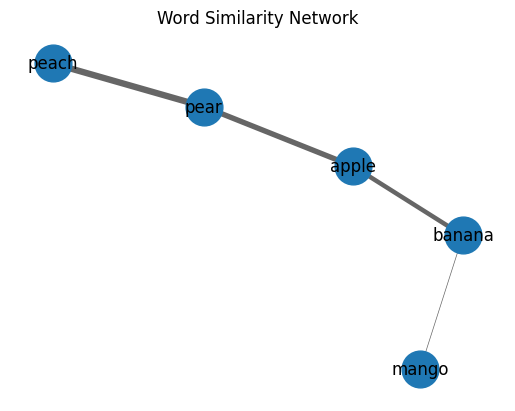

In [207]:
import networkx as nx
import matplotlib.pyplot as plt

# 1. Build your graph
G = nx.Graph()
# Suppose you have a list of (word_a, word_b, similarity_score)
edges = [
    ('apple', 'pear', 0.78),
    ('apple', 'banana', 0.65),
    ('pear',  'peach', 0.92),
    ('banana','mango', 0.10),
]
# Add edges with a weight attribute
for a, b, w in edges:
    G.add_edge(a, b, weight=w)

# 2. Choose a layout
pos = nx.spring_layout(G, k=0.5)  # force‐directed layout

# 3. Draw nodes & edges
nx.draw_networkx_nodes(G, pos, node_size=700)
nx.draw_networkx_labels(G, pos, font_size=12)
# scale edge widths by weight
weights = [G[u][v]['weight']*5 for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, width=weights, alpha=0.6)

# 4. Show
plt.axis('off')
plt.title("Word Similarity Network")
plt.show()


In [8]:
import pandas as pd
lippath = '/Users/pabloherrero/Documents/ManHatTan/mht/data/processed/LIPSTICK/hebrew_db_team.lip'
lip = pd.read_csv(lippath)

In [11]:
lip = lip.drop(lip[lip['rebag'] == True].index)
len(lip)

0

In [13]:
lip.iloc[0]

IndexError: single positional indexer is out-of-bounds